<a href="https://colab.research.google.com/github/Paulymorphous/MNIST-Gan/blob/master/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
base_path = "gdrive/My\ Drive/GAN/"
%cd gdrive/My\ Drive/GAN/

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/GAN


#1. Import Libraries

In [2]:
#Utils
import os
import numpy as np
from tqdm import tqdm_notebook, tqdm
from skimage.io import imshow
from matplotlib import pyplot as plt
import random
import math
from datetime import datetime

#Keras
from tensorflow.keras.layers import Input, Reshape, Dense, Dropout, Flatten, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

#Constants
latent_input_dimension = 100
input_shape = (28, 28, 1)

## 2. Loading Data

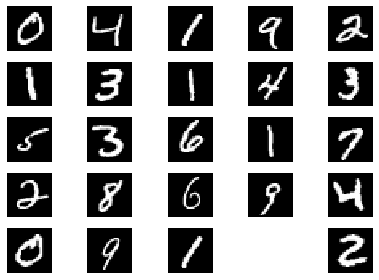


Shape of image: (60000, 28, 28)


In [3]:
(X_train, _), (_, _) = mnist.load_data()
images = X_train.astype(np.float32)/255.0

num_samples = 25
sqrt = int(math.sqrt(num_samples))

for n in range(1, num_samples+1):
	plt.subplot(sqrt, sqrt, n)
	plt.axis('off')
	imshow(images[n])
plt.show();

images = np.expand_dims(images, -1)
print("\nShape of image: {}".format(X_train.shape))

### Writing Data Loader Functions

In [0]:
def generate_real_train_batch(images, batch_size):
  rand_vals = [random.randrange(0, images.shape[0]) for n in range(batch_size)]
  return images[rand_vals], np.ones((batch_size, 1))
  
def generate_latent_space_points(batch_size):
  latent_space = np.random.randn(latent_input_dimension * batch_size)
  latent_space = latent_space.reshape(batch_size, latent_input_dimension)
  return latent_space

def generate_fake_train_batch(generator, batch_size):
  latent_input = generate_latent_space_points(batch_size)
  fake_samples = generator.predict(latent_input)
  return fake_samples, np.zeros((batch_size, 1))

## 3. Neural Modelling

### 3.1 Building the generator

In [5]:
generator = Sequential()

generator.add(Dense(128*7*7, input_dim=latent_input_dimension))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7, 7, 128)))
generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(Conv2D(1, kernel_size=(7, 7), padding='same', activation='sigmoid'))
print(generator.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________

### 3.2 Building the Discriminator

In [6]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1), kernel_initializer='he_normal'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.4))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.4))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
print(discriminator.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

### 3.3 compiling the models

In [7]:
learning_rate = 0.0002
beta = 0.5
batch_size = 64
num_display_samples = 25
half_batch = int(batch_size/2)
epochs = 200
steps_per_epoch = int(images.shape[0]/batch_size)


adam = Adam(lr=learning_rate, beta_1=beta)
generator.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=adam)
discriminator.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=adam)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### 3.4 Training Discriminator

In [8]:
gan = Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss='binary_crossentropy', optimizer=adam)
print(gan.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,377,154
Trainable params: 1,377,154
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
def plot_images(images, num_samples):
  
  sqrt = int(math.sqrt(num_samples))

  for n in range(1, num_samples+1):
    ix = random.randint(1,999)
    plt.subplot(sqrt, sqrt, n)
    plt.axis('off')
    imshow(images[ix][:,:, 0])
  
  plt.show();

def saveModels(epoch):
    generator.save('./Models/dcgan_generator_epoch_%d.h5' % epoch)
    discriminator.save('./Models/dcgan_discriminator_epoch_%d.h5' % epoch)

Total Training Progress:




EPOCH 001:


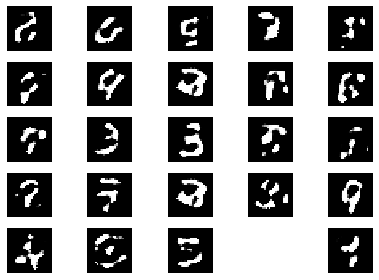

Time: 0.44355 | D Loss: 0.85790 | G Loss: 0.31755
Gan loss improved from 0.31755 to 0.31755. Saving the model.

EPOCH 002:


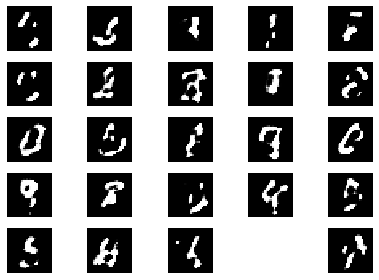

Time: 0.39146 | D Loss: 0.81237 | G Loss: 0.30994
Gan loss improved from 0.30994 to 0.30994. Saving the model.

EPOCH 003:


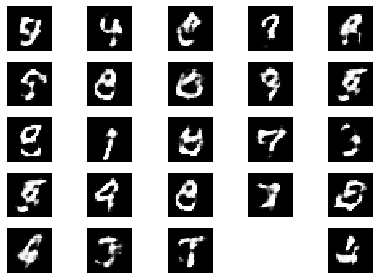

Time: 0.39260 | D Loss: 0.84115 | G Loss: 0.29186
Gan loss improved from 0.29186 to 0.29186. Saving the model.

EPOCH 004:


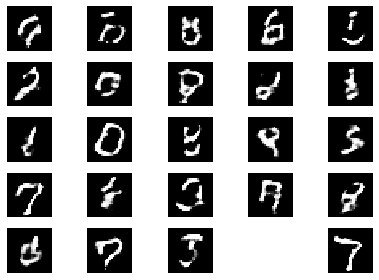

Time: 0.39312 | D Loss: 0.83440 | G Loss: 0.30056

EPOCH 005:


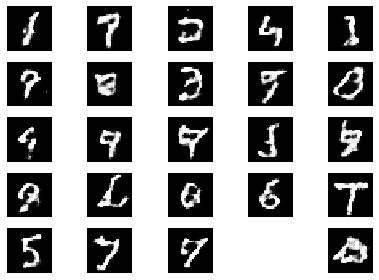

Time: 0.38924 | D Loss: 0.84342 | G Loss: 0.30054

EPOCH 006:


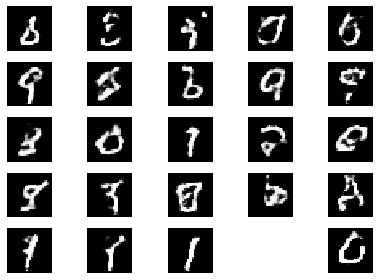

Time: 0.39305 | D Loss: 0.82473 | G Loss: 0.29996

EPOCH 007:


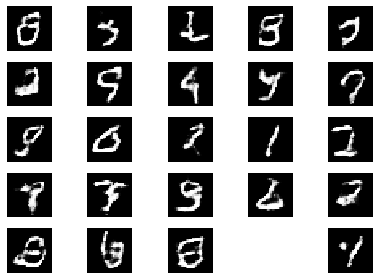

Time: 0.39287 | D Loss: 0.82997 | G Loss: 0.29809

EPOCH 008:


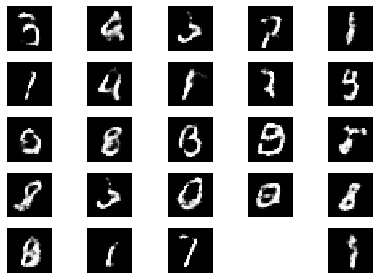

Time: 0.39560 | D Loss: 0.84402 | G Loss: 0.29324

EPOCH 009:


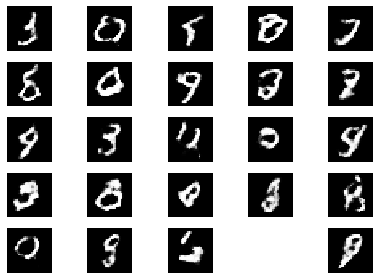

Time: 0.38582 | D Loss: 0.83102 | G Loss: 0.30061

EPOCH 010:


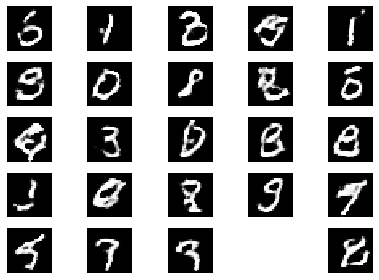

Time: 0.38616 | D Loss: 0.84788 | G Loss: 0.29524

EPOCH 011:


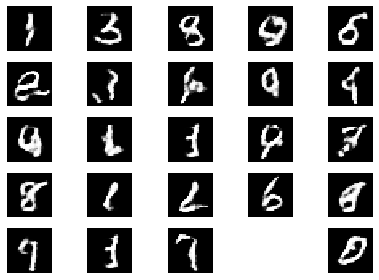

Time: 0.38312 | D Loss: 0.84094 | G Loss: 0.28966
Gan loss improved from 0.28966 to 0.28966. Saving the model.

EPOCH 012:


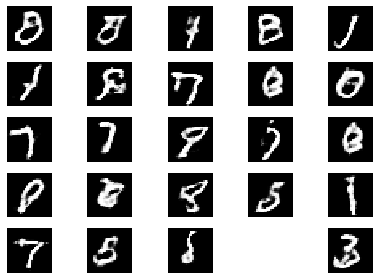

Time: 0.38277 | D Loss: 0.84526 | G Loss: 0.29297

EPOCH 013:


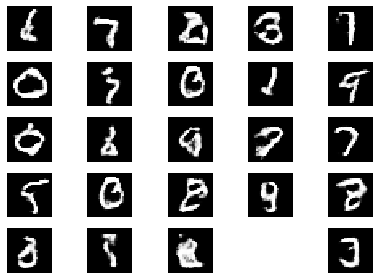

Time: 0.38227 | D Loss: 0.84133 | G Loss: 0.29473

EPOCH 014:


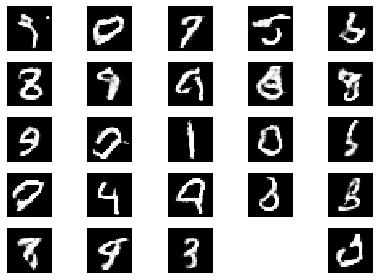

Time: 0.38710 | D Loss: 0.83745 | G Loss: 0.29614

EPOCH 015:


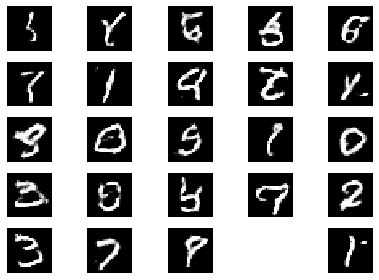

Time: 0.38091 | D Loss: 0.84065 | G Loss: 0.28902
Gan loss improved from 0.28902 to 0.28902. Saving the model.

EPOCH 016:


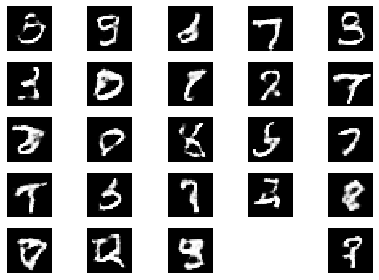

Time: 0.38319 | D Loss: 0.83067 | G Loss: 0.29602

EPOCH 017:


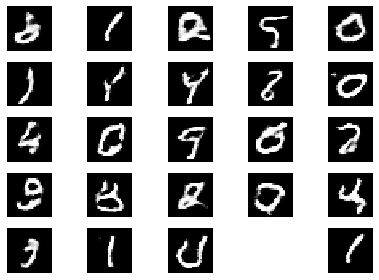

Time: 0.37696 | D Loss: 0.83952 | G Loss: 0.29394

EPOCH 018:


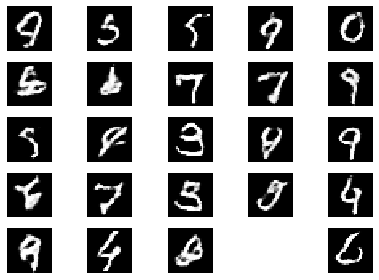

Time: 0.38102 | D Loss: 0.84144 | G Loss: 0.29358

EPOCH 019:


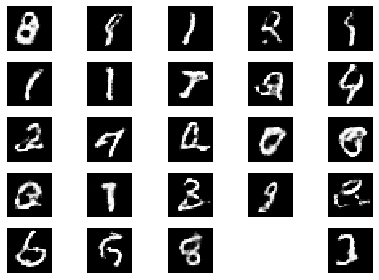

Time: 0.37593 | D Loss: 0.83828 | G Loss: 0.29371

EPOCH 020:


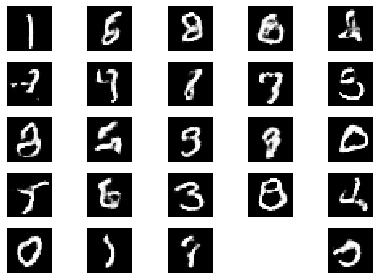

Time: 0.37849 | D Loss: 0.84801 | G Loss: 0.29519

EPOCH 021:


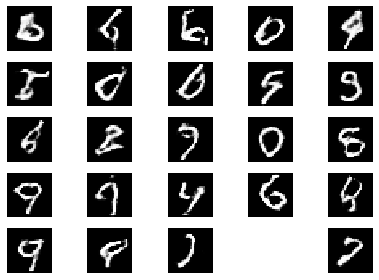

Time: 0.37666 | D Loss: 0.85436 | G Loss: 0.29374

EPOCH 022:


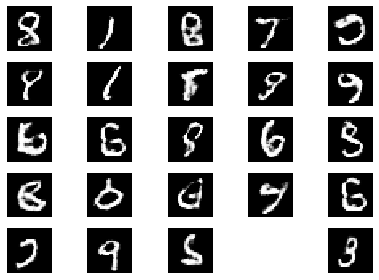

Time: 0.37814 | D Loss: 0.84161 | G Loss: 0.28921

EPOCH 023:


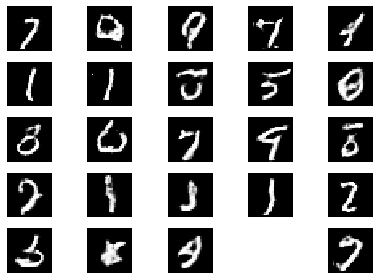

Time: 0.37308 | D Loss: 0.84942 | G Loss: 0.29357

EPOCH 024:


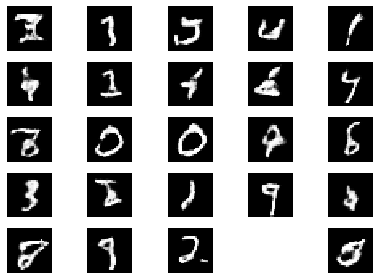

Time: 0.37796 | D Loss: 0.83807 | G Loss: 0.29554

EPOCH 025:


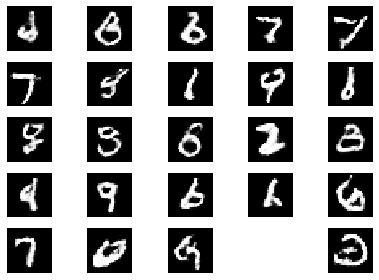

Time: 0.37508 | D Loss: 0.83173 | G Loss: 0.29604

EPOCH 026:


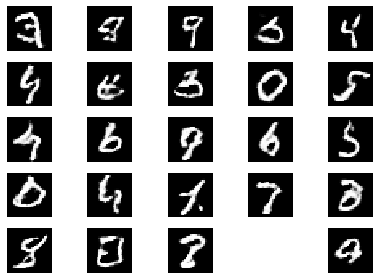

Time: 0.37691 | D Loss: 0.83110 | G Loss: 0.29489

EPOCH 027:


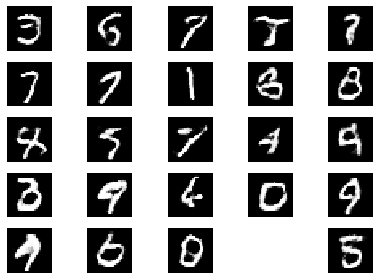

Time: 0.37710 | D Loss: 0.84461 | G Loss: 0.29236

EPOCH 028:


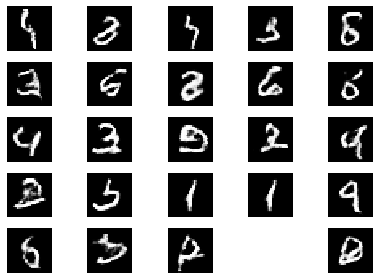

Time: 0.37763 | D Loss: 0.84151 | G Loss: 0.29195

EPOCH 029:


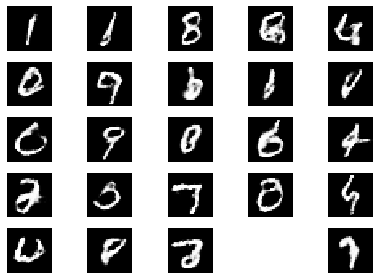

Time: 0.37453 | D Loss: 0.83780 | G Loss: 0.29405

EPOCH 030:


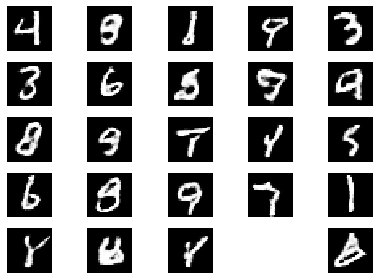

Time: 0.37510 | D Loss: 0.83627 | G Loss: 0.29651

EPOCH 031:


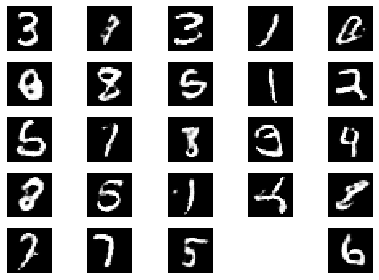

Time: 0.37306 | D Loss: 0.84043 | G Loss: 0.28990

EPOCH 032:


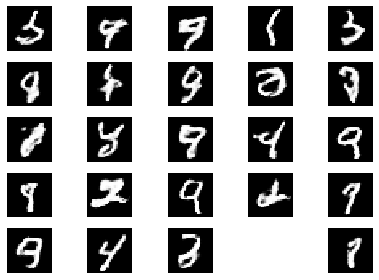

Time: 0.37718 | D Loss: 0.83126 | G Loss: 0.29276

EPOCH 033:


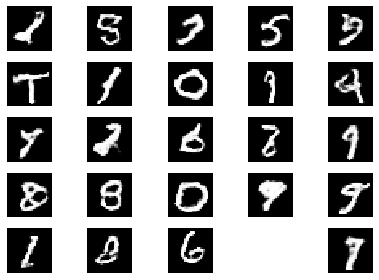

Time: 0.37191 | D Loss: 0.83259 | G Loss: 0.28833
Gan loss improved from 0.28833 to 0.28833. Saving the model.

EPOCH 034:


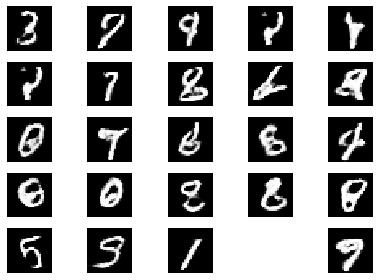

Time: 0.37566 | D Loss: 0.83902 | G Loss: 0.29485

EPOCH 035:


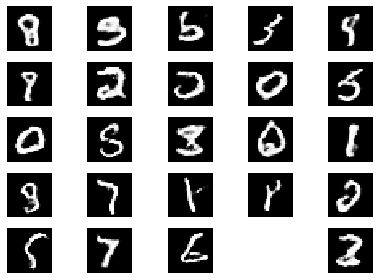

Time: 0.37134 | D Loss: 0.83359 | G Loss: 0.29142

EPOCH 036:


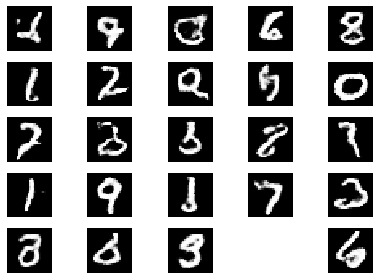

Time: 0.37602 | D Loss: 0.84775 | G Loss: 0.29399

EPOCH 037:


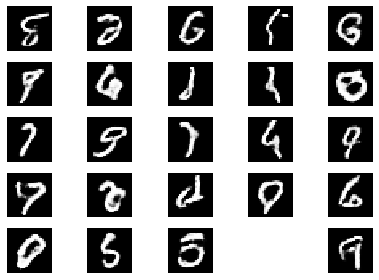

Time: 0.37187 | D Loss: 0.84471 | G Loss: 0.29201

EPOCH 038:


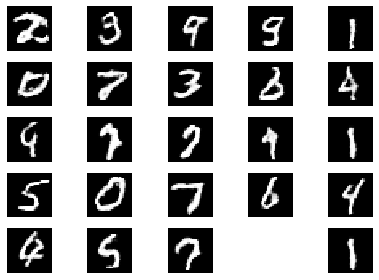

Time: 0.37381 | D Loss: 0.83143 | G Loss: 0.28627
Gan loss improved from 0.28627 to 0.28627. Saving the model.

EPOCH 039:


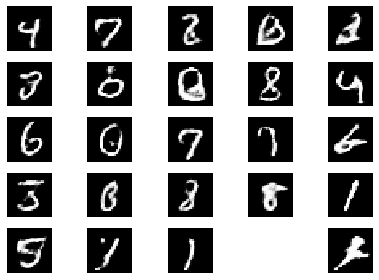

Time: 0.37445 | D Loss: 0.83411 | G Loss: 0.28872

EPOCH 040:


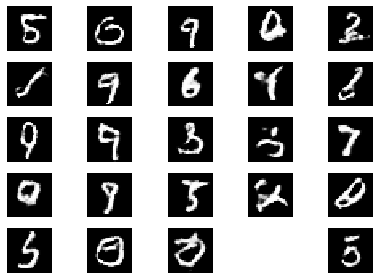

Time: 0.37582 | D Loss: 0.84506 | G Loss: 0.29103

EPOCH 041:


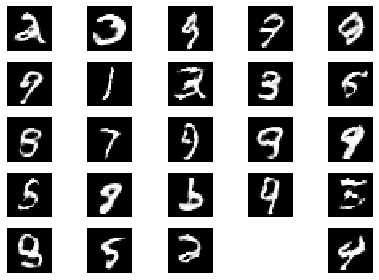

Time: 0.37621 | D Loss: 0.82996 | G Loss: 0.29227

EPOCH 042:


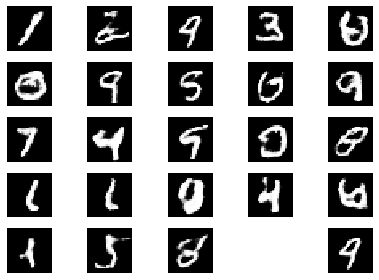

Time: 0.37448 | D Loss: 0.84284 | G Loss: 0.28319
Gan loss improved from 0.28319 to 0.28319. Saving the model.

EPOCH 043:


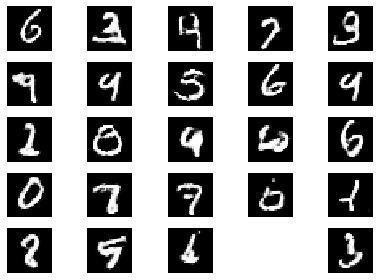

Time: 0.37395 | D Loss: 0.83976 | G Loss: 0.29546

EPOCH 044:


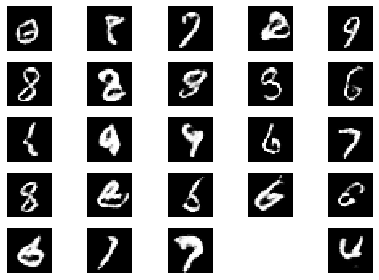

Time: 0.37483 | D Loss: 0.83847 | G Loss: 0.29300

EPOCH 045:


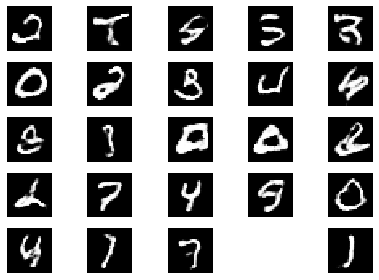

Time: 0.37256 | D Loss: 0.83028 | G Loss: 0.28212
Gan loss improved from 0.28212 to 0.28212. Saving the model.

EPOCH 046:


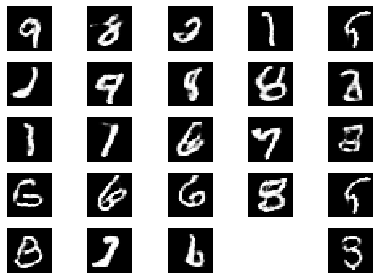

Time: 0.37722 | D Loss: 0.84294 | G Loss: 0.28247

EPOCH 047:


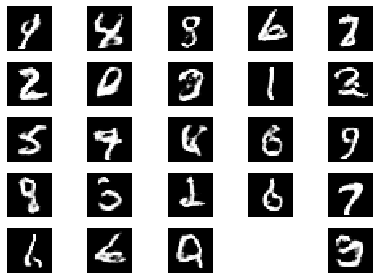

Time: 0.37116 | D Loss: 0.83600 | G Loss: 0.28802

EPOCH 048:


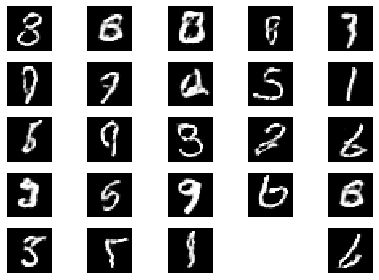

Time: 0.37518 | D Loss: 0.82279 | G Loss: 0.29425

EPOCH 049:


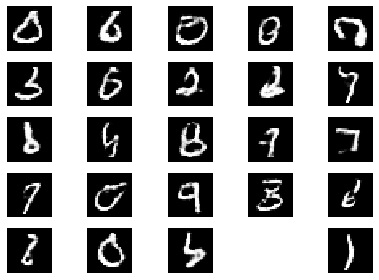

Time: 0.37090 | D Loss: 0.84019 | G Loss: 0.29112

EPOCH 050:


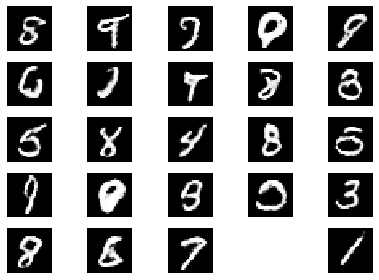

Time: 0.37649 | D Loss: 0.84380 | G Loss: 0.29409

EPOCH 051:


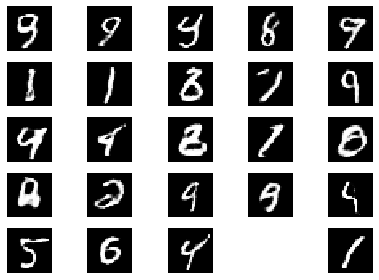

Time: 0.37121 | D Loss: 0.83879 | G Loss: 0.29169

EPOCH 052:


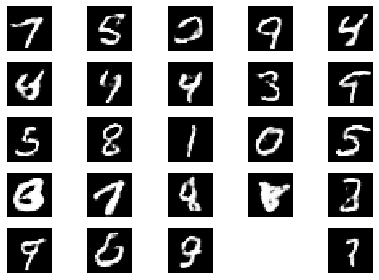

Time: 0.37286 | D Loss: 0.83197 | G Loss: 0.29425

EPOCH 053:


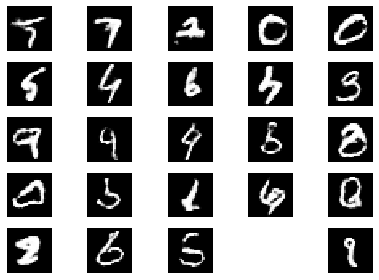

Time: 0.37361 | D Loss: 0.85075 | G Loss: 0.28717

EPOCH 054:


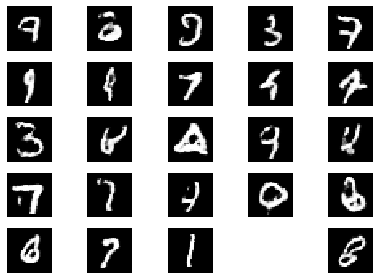

Time: 0.37440 | D Loss: 0.85306 | G Loss: 0.28690

EPOCH 055:


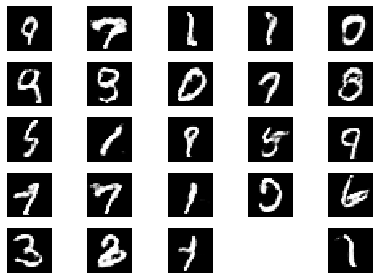

Time: 0.37485 | D Loss: 0.82832 | G Loss: 0.29106

EPOCH 056:


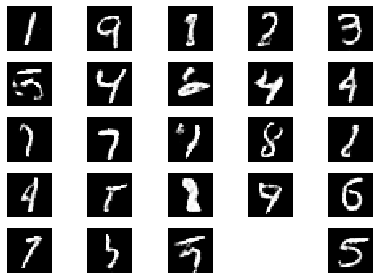

Time: 0.37396 | D Loss: 0.83163 | G Loss: 0.28859

EPOCH 057:


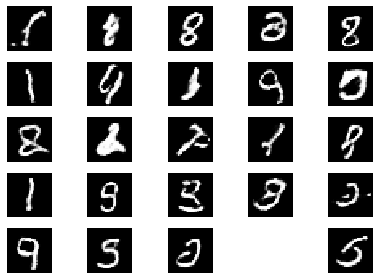

Time: 0.37331 | D Loss: 0.83223 | G Loss: 0.29553

EPOCH 058:


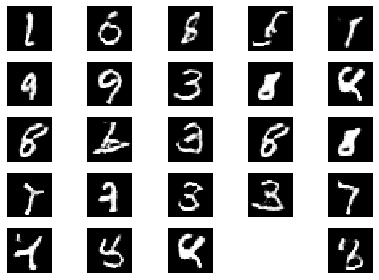

Time: 0.37367 | D Loss: 0.83705 | G Loss: 0.29079

EPOCH 059:


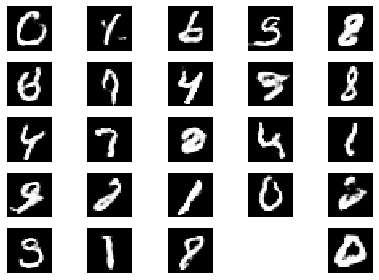

Time: 0.37196 | D Loss: 0.84232 | G Loss: 0.28760

EPOCH 060:


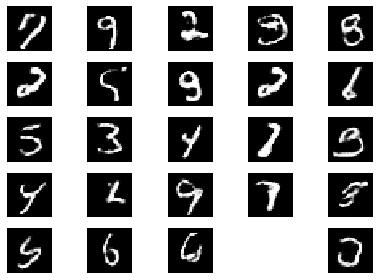

Time: 0.37532 | D Loss: 0.83515 | G Loss: 0.29161

EPOCH 061:


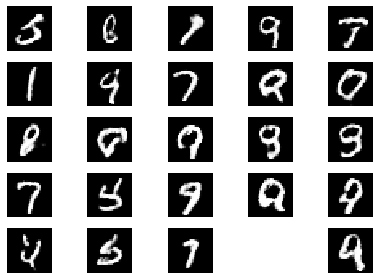

Time: 0.37252 | D Loss: 0.84793 | G Loss: 0.29000

EPOCH 062:


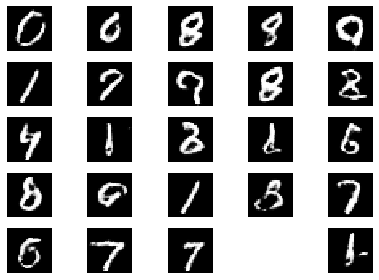

Time: 0.37440 | D Loss: 0.83263 | G Loss: 0.28934

EPOCH 063:


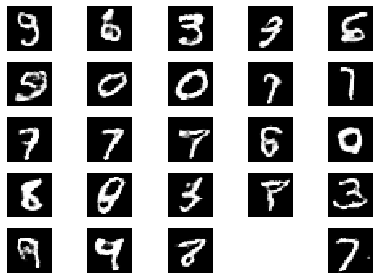

Time: 0.37158 | D Loss: 0.85175 | G Loss: 0.29313

EPOCH 064:


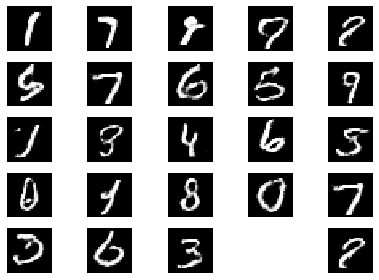

Time: 0.37589 | D Loss: 0.84261 | G Loss: 0.29718

EPOCH 065:


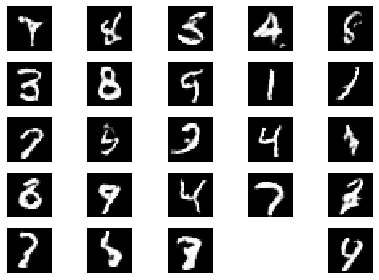

Time: 0.37213 | D Loss: 0.84301 | G Loss: 0.29227

EPOCH 066:


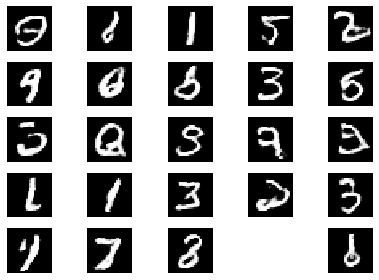

Time: 0.37328 | D Loss: 0.83270 | G Loss: 0.29097

EPOCH 067:


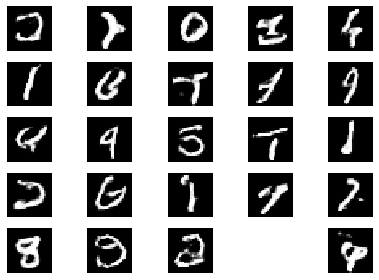

Time: 0.37304 | D Loss: 0.82448 | G Loss: 0.29337

EPOCH 068:


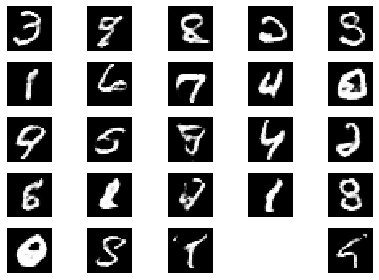

Time: 0.37484 | D Loss: 0.83482 | G Loss: 0.29173

EPOCH 069:


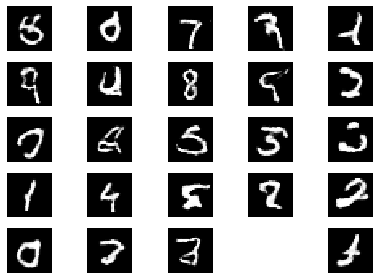

Time: 0.37540 | D Loss: 0.84485 | G Loss: 0.29114

EPOCH 070:


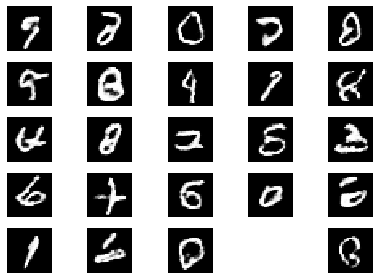

Time: 0.37353 | D Loss: 0.83563 | G Loss: 0.28823

EPOCH 071:


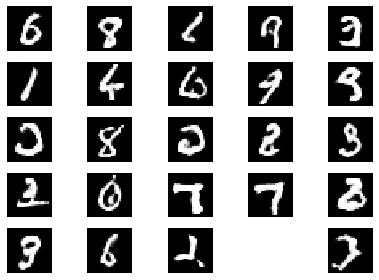

Time: 0.37149 | D Loss: 0.83763 | G Loss: 0.28771

EPOCH 072:


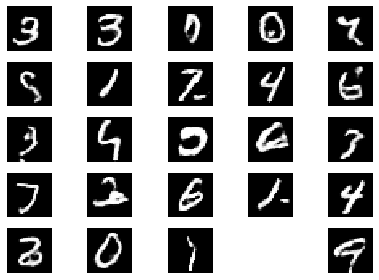

Time: 0.37417 | D Loss: 0.84154 | G Loss: 0.29247

EPOCH 073:


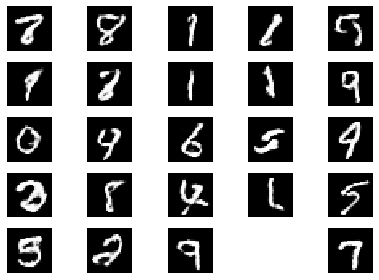

Time: 0.37143 | D Loss: 0.84356 | G Loss: 0.28739

EPOCH 074:


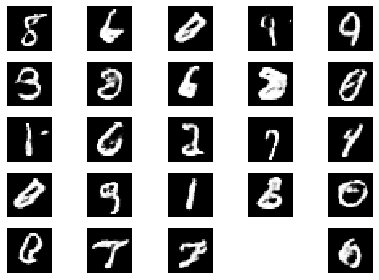

Time: 0.37444 | D Loss: 0.84074 | G Loss: 0.29141

EPOCH 075:


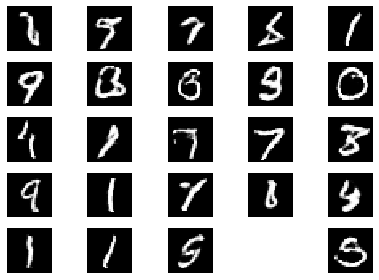

Time: 0.37290 | D Loss: 0.83906 | G Loss: 0.28952

EPOCH 076:


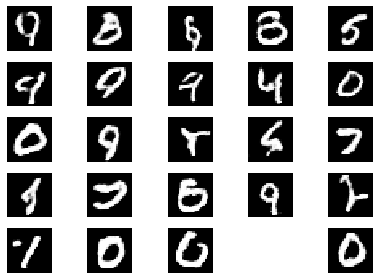

Time: 0.37412 | D Loss: 0.83491 | G Loss: 0.29138

EPOCH 077:


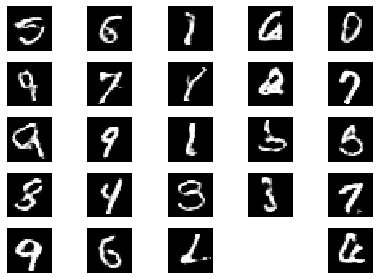

Time: 0.37249 | D Loss: 0.83805 | G Loss: 0.28963

EPOCH 078:


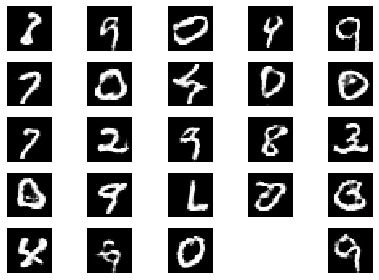

Time: 0.37294 | D Loss: 0.84248 | G Loss: 0.29003

EPOCH 079:


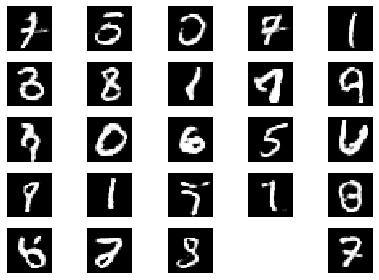

Time: 0.37213 | D Loss: 0.83380 | G Loss: 0.29494

EPOCH 080:


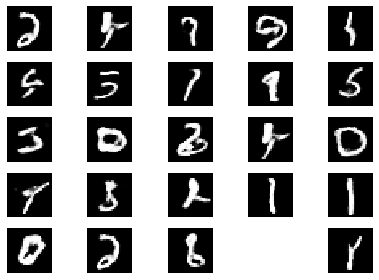

Time: 0.40464 | D Loss: 0.84123 | G Loss: 0.28875

EPOCH 081:


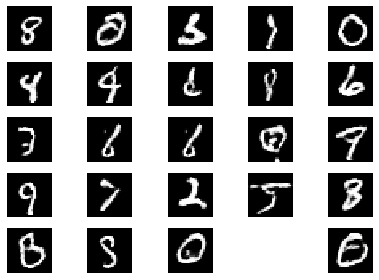

Time: 0.37534 | D Loss: 0.84215 | G Loss: 0.29278

EPOCH 082:


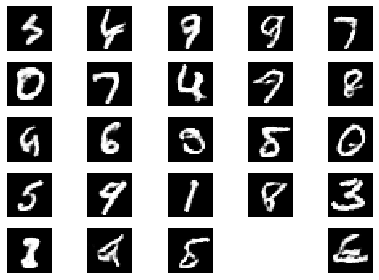

Time: 0.38090 | D Loss: 0.84419 | G Loss: 0.28625

EPOCH 083:


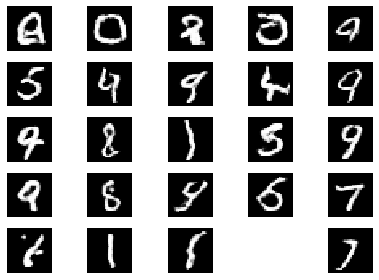

Time: 0.37807 | D Loss: 0.84026 | G Loss: 0.29124

EPOCH 084:


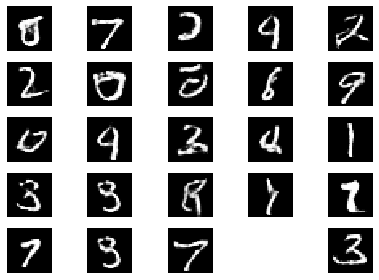

Time: 0.37955 | D Loss: 0.84241 | G Loss: 0.29279

EPOCH 085:


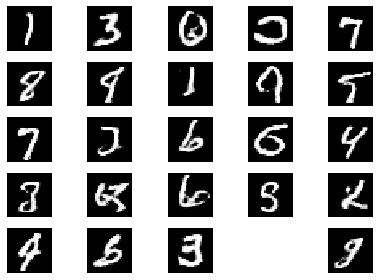

Time: 0.37578 | D Loss: 0.85165 | G Loss: 0.28670

EPOCH 086:


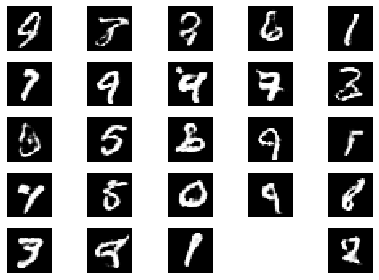

Time: 0.38320 | D Loss: 0.83930 | G Loss: 0.28893

EPOCH 087:


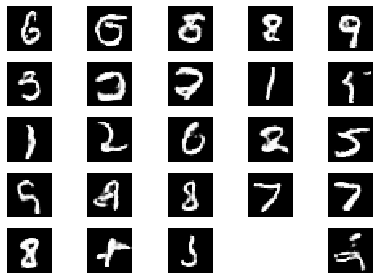

Time: 0.37967 | D Loss: 0.84770 | G Loss: 0.28696

EPOCH 088:


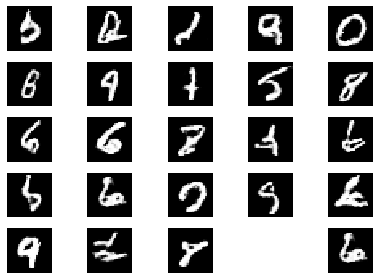

Time: 0.38403 | D Loss: 0.83927 | G Loss: 0.29032

EPOCH 089:


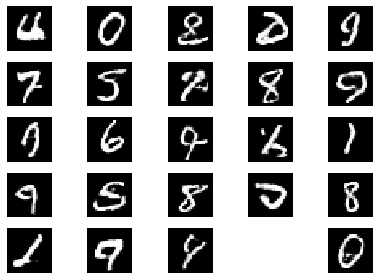

Time: 0.38164 | D Loss: 0.84517 | G Loss: 0.28968

EPOCH 090:


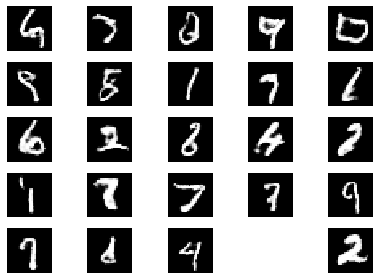

Time: 0.38109 | D Loss: 0.83326 | G Loss: 0.29279

EPOCH 091:


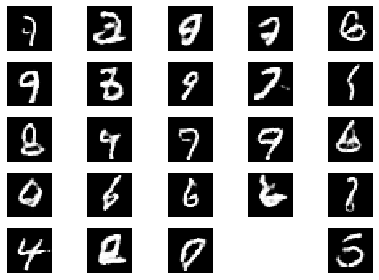

Time: 0.38182 | D Loss: 0.83552 | G Loss: 0.29389

EPOCH 092:


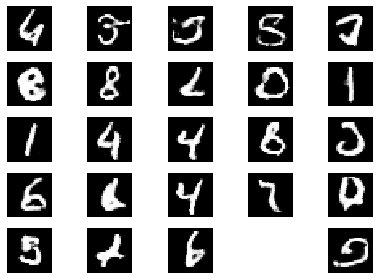

Time: 0.38154 | D Loss: 0.83744 | G Loss: 0.29158

EPOCH 093:


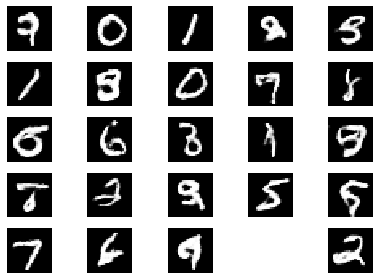

Time: 0.38079 | D Loss: 0.83922 | G Loss: 0.29234

EPOCH 094:


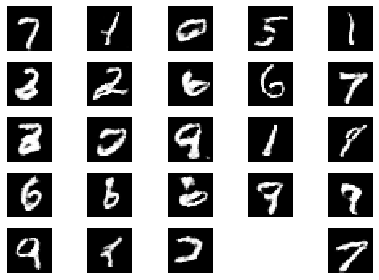

Time: 0.37670 | D Loss: 0.83843 | G Loss: 0.29012

EPOCH 095:


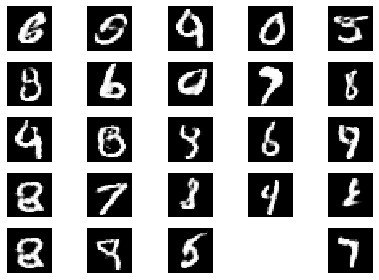

Time: 0.37743 | D Loss: 0.84213 | G Loss: 0.29318

EPOCH 096:


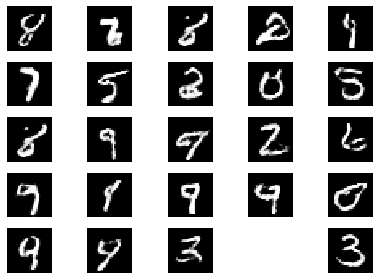

Time: 0.37979 | D Loss: 0.83864 | G Loss: 0.28940

EPOCH 097:


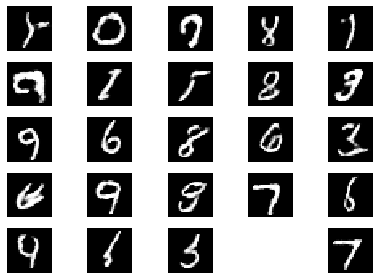

Time: 0.37739 | D Loss: 0.84266 | G Loss: 0.29104

EPOCH 098:


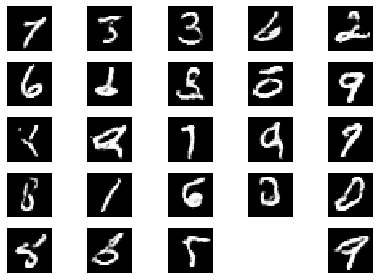

Time: 0.37561 | D Loss: 0.83785 | G Loss: 0.28405

EPOCH 099:


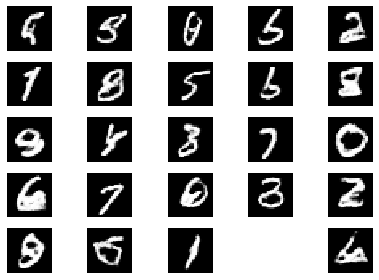

Time: 0.37671 | D Loss: 0.82770 | G Loss: 0.28788

EPOCH 100:


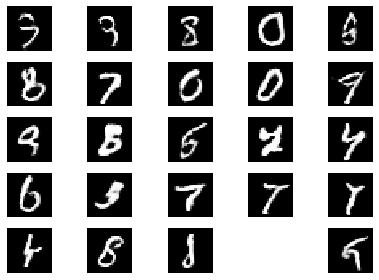

Time: 0.38097 | D Loss: 0.84670 | G Loss: 0.28710

EPOCH 101:


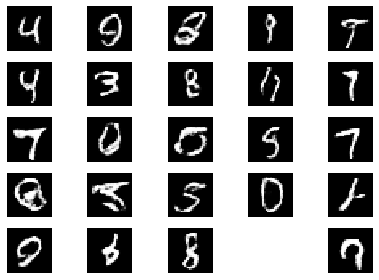

Time: 0.38246 | D Loss: 0.84757 | G Loss: 0.28631

EPOCH 102:


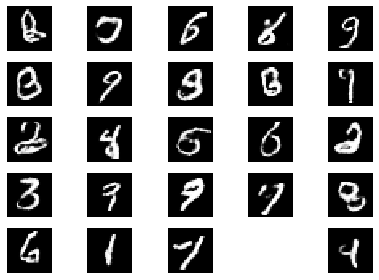

Time: 0.38251 | D Loss: 0.83921 | G Loss: 0.29105

EPOCH 103:


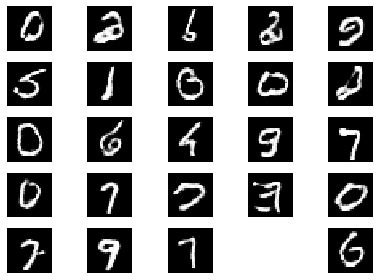

Time: 0.38776 | D Loss: 0.84451 | G Loss: 0.28769

EPOCH 104:


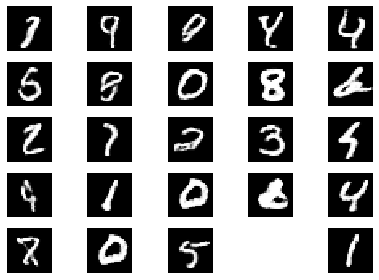

Time: 0.38320 | D Loss: 0.83216 | G Loss: 0.28502

EPOCH 105:


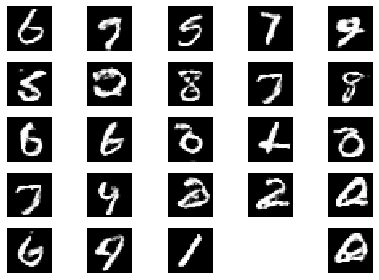

Time: 0.38324 | D Loss: 0.84022 | G Loss: 0.29058

EPOCH 106:


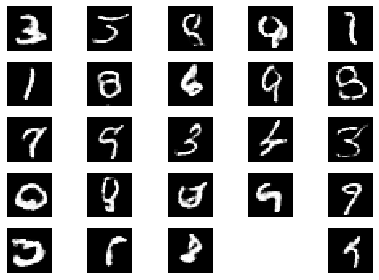

Time: 0.38153 | D Loss: 0.83859 | G Loss: 0.28653

EPOCH 107:


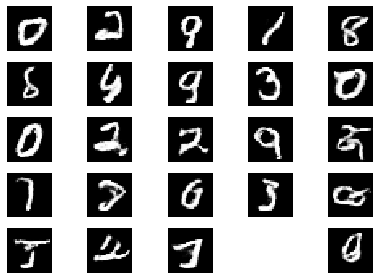

Time: 0.38437 | D Loss: 0.84166 | G Loss: 0.29103

EPOCH 108:


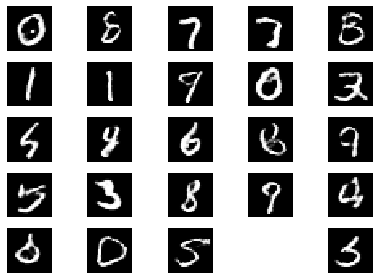

Time: 0.38199 | D Loss: 0.83106 | G Loss: 0.29015

EPOCH 109:


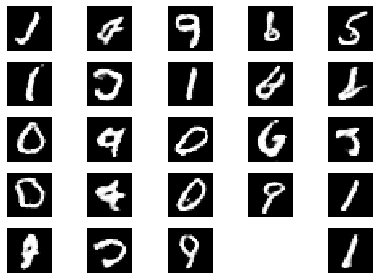

Time: 0.38671 | D Loss: 0.83111 | G Loss: 0.28362

EPOCH 110:


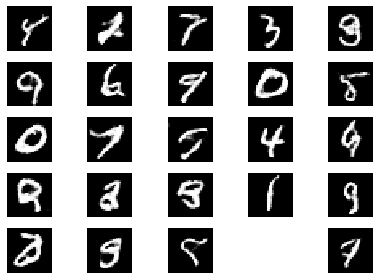

Time: 0.38227 | D Loss: 0.84589 | G Loss: 0.29339

EPOCH 111:


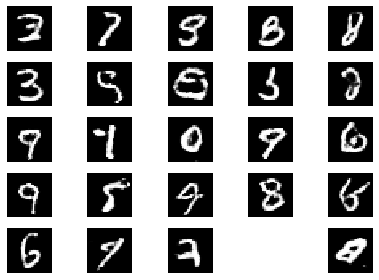

Time: 0.37730 | D Loss: 0.83634 | G Loss: 0.28892

EPOCH 112:


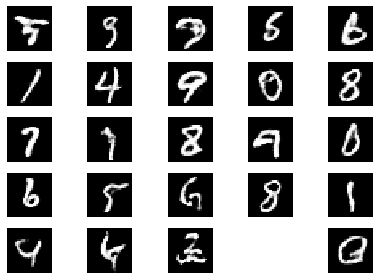

Time: 0.37500 | D Loss: 0.83168 | G Loss: 0.28946

EPOCH 113:


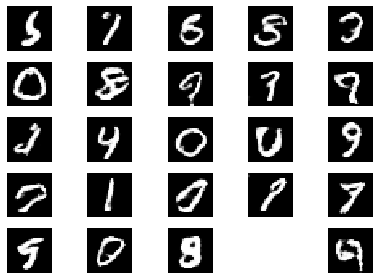

Time: 0.37636 | D Loss: 0.85304 | G Loss: 0.29328

EPOCH 114:


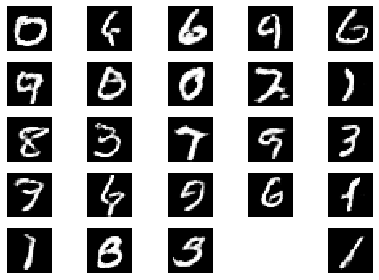

Time: 0.37724 | D Loss: 0.83897 | G Loss: 0.29018

EPOCH 115:


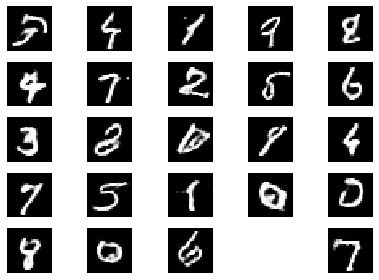

Time: 0.37791 | D Loss: 0.83934 | G Loss: 0.29057

EPOCH 116:


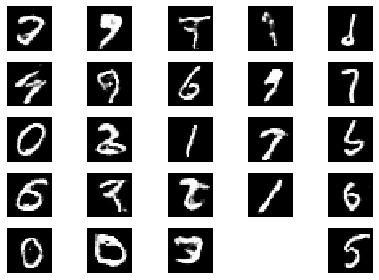

Time: 0.37373 | D Loss: 0.84391 | G Loss: 0.28690

EPOCH 117:


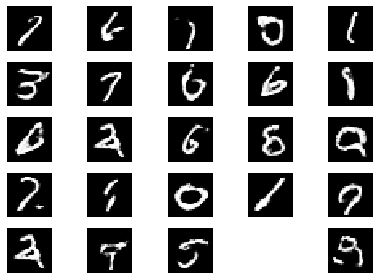

Time: 0.37863 | D Loss: 0.83888 | G Loss: 0.29217

EPOCH 118:


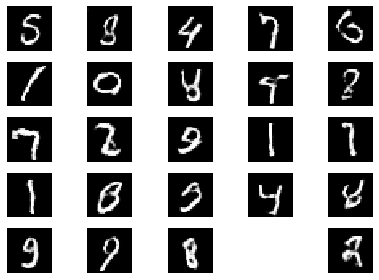

Time: 0.37638 | D Loss: 0.84492 | G Loss: 0.29094

EPOCH 119:


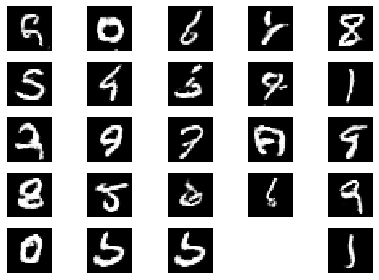

Time: 0.37780 | D Loss: 0.83126 | G Loss: 0.29062

EPOCH 120:


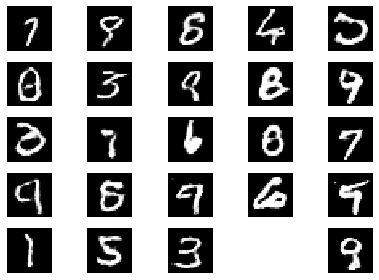

Time: 0.37448 | D Loss: 0.84356 | G Loss: 0.28653

EPOCH 121:


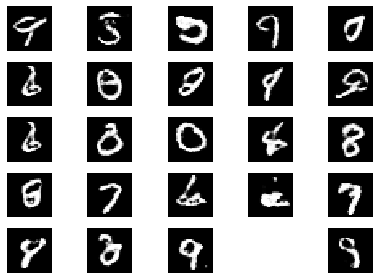

Time: 0.37928 | D Loss: 0.83199 | G Loss: 0.29017

EPOCH 122:


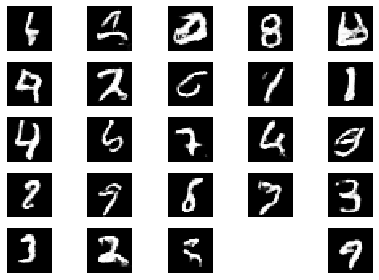

Time: 0.37490 | D Loss: 0.83948 | G Loss: 0.28649

EPOCH 123:


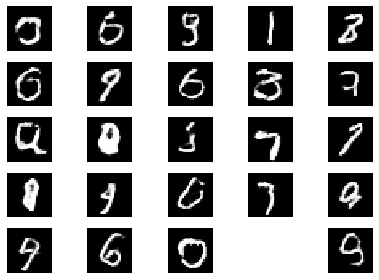

Time: 0.37906 | D Loss: 0.84047 | G Loss: 0.28655

EPOCH 124:


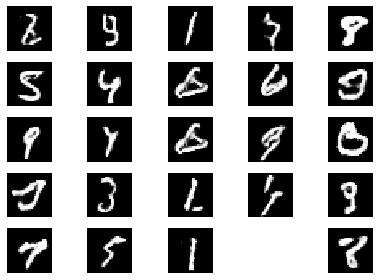

Time: 0.37725 | D Loss: 0.83765 | G Loss: 0.29027

EPOCH 125:


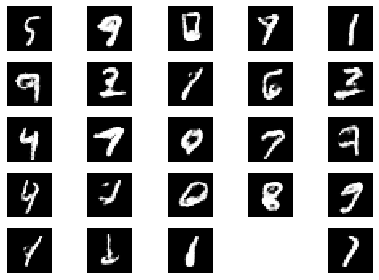

Time: 0.37607 | D Loss: 0.83601 | G Loss: 0.29025

EPOCH 126:


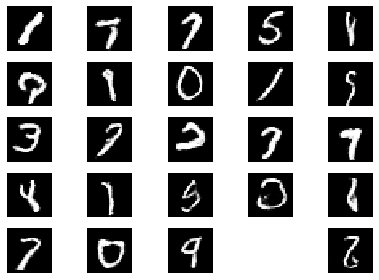

Time: 0.37393 | D Loss: 0.83377 | G Loss: 0.29373

EPOCH 127:


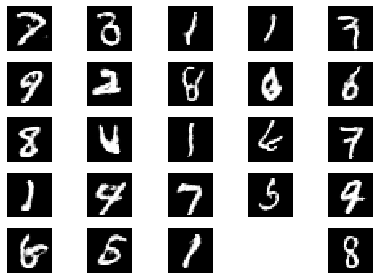

Time: 0.37733 | D Loss: 0.84797 | G Loss: 0.28395

EPOCH 128:


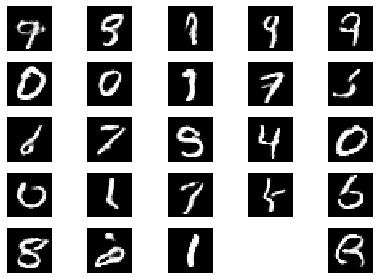

Time: 0.37667 | D Loss: 0.84581 | G Loss: 0.28664

EPOCH 129:


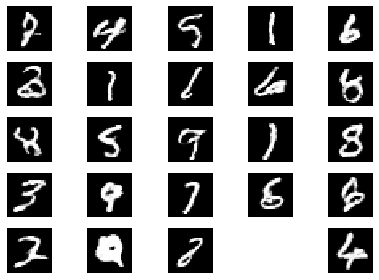

Time: 0.37669 | D Loss: 0.83997 | G Loss: 0.29369

EPOCH 130:


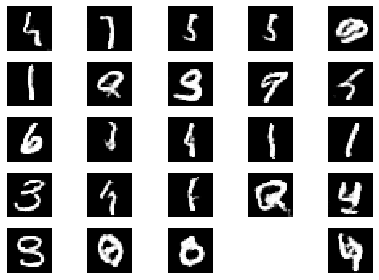

Time: 0.37488 | D Loss: 0.84886 | G Loss: 0.29298

EPOCH 131:


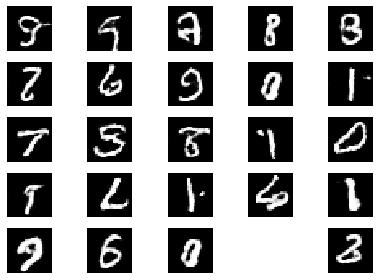

Time: 0.37711 | D Loss: 0.83473 | G Loss: 0.29141

EPOCH 132:


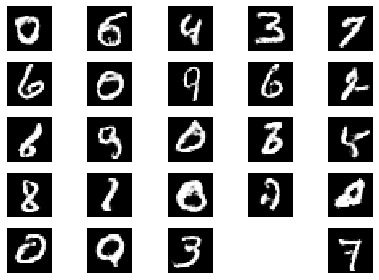

Time: 0.37476 | D Loss: 0.83765 | G Loss: 0.29108

EPOCH 133:


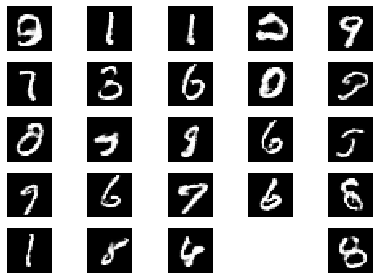

Time: 0.37730 | D Loss: 0.83170 | G Loss: 0.28841

EPOCH 134:


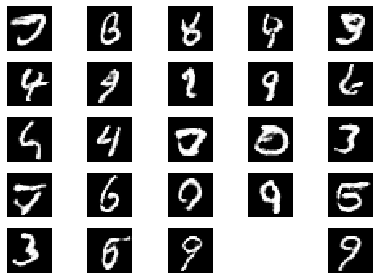

Time: 0.37463 | D Loss: 0.83890 | G Loss: 0.28595

EPOCH 135:


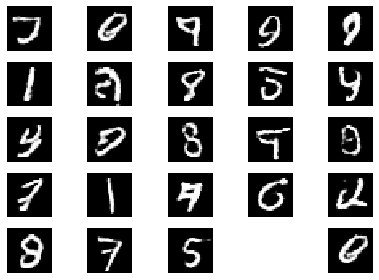

Time: 0.37866 | D Loss: 0.83626 | G Loss: 0.29193

EPOCH 136:


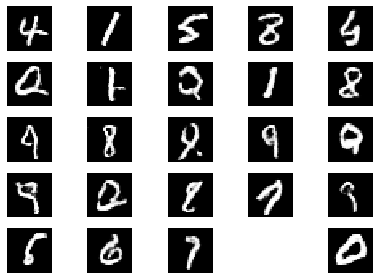

Time: 0.37281 | D Loss: 0.83722 | G Loss: 0.28886

EPOCH 137:


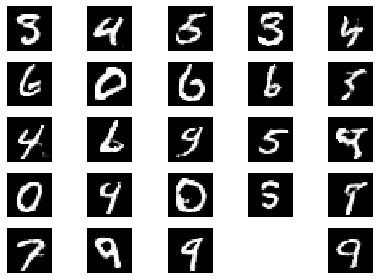

Time: 0.38161 | D Loss: 0.83235 | G Loss: 0.28937

EPOCH 138:


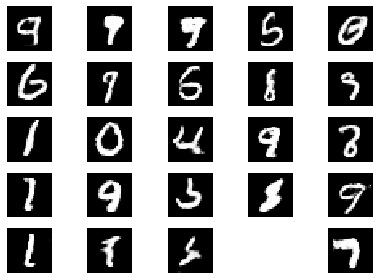

Time: 0.37442 | D Loss: 0.84449 | G Loss: 0.29097

EPOCH 139:


In [0]:
print('Total Training Progress:\n')
prev_g_loss = 999
for epoch in tqdm_notebook(range(1, epochs+1), total = epochs):
  start_time = datetime.now()
  print("\nEPOCH {:0>3d}:".format(epoch))
  for step in tqdm_notebook(range(steps_per_epoch), total = steps_per_epoch):
    real_images, real_labels = generate_real_train_batch(images, half_batch)
    fake_images, fake_labels = generate_fake_train_batch(generator, half_batch)

    discriminator_images, discriminator_labels = np.vstack((real_images, fake_images)), np.vstack((real_labels, fake_labels))

    disc_loss, _ =  discriminator.train_on_batch(discriminator_images, discriminator_labels)

    gan_images = generate_latent_space_points(batch_size)
    gan_labels = np.ones((batch_size, 1))

    gan_loss = gan.train_on_batch(gan_images, gan_labels)
  
  generated_images,_ = generate_fake_train_batch(generator,1000)
  plot_images(generated_images, num_display_samples)

  epoch_time = datetime.now() - start_time
  text_template = "Time: {:.5f} | D Loss: {:.5f} | G Loss: {:.5f}"
  print(text_template.format((epoch_time.total_seconds()), disc_loss, gan_loss))

  if (gan_loss < prev_g_loss):
    prev_g_loss = gan_loss
    saveModels(epoch)
    print("Gan loss improved from {:.5f} to {:.5f}. Saving the model.".format(prev_g_loss, gan_loss)) 
  